In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install idx2numpy --quiet

In [3]:
import idx2numpy
import gzip
import numpy as np
import matplotlib.pyplot as plt
import time
import os
from collections import OrderedDict

## Data load

In [4]:
def label_to_array(f, num_data):
    f.read(8)
    labels = []
    for _ in range(num_data):
        buf = f.read(1)
        label = np.frombuffer(buf, dtype = np.uint8).astype(np.int64)[0]
        labels.append(label)
    return labels

data_path = "./drive/MyDrive"
f = gzip.open(os.path.join(data_path, 'train-images-idx3-ubyte.gz'), 'r')
train_X = np.array(idx2numpy.convert_from_file(f) / 255)
f = gzip.open(os.path.join(data_path, 't10k-images-idx3-ubyte.gz'), 'r')
test_X = np.array(idx2numpy.convert_from_file(f) / 255)
f = gzip.open(os.path.join(data_path, 'train-labels-idx1-ubyte.gz'), 'r')
train_y = np.array(label_to_array(f, train_X.shape[0]))
f = gzip.open(os.path.join(data_path, 't10k-labels-idx1-ubyte.gz'), 'r')
test_y = np.array(label_to_array(f, test_X.shape[0]))
del f

In [5]:
# one-hot encoding
train_Y = np.zeros((len(train_y),10))
test_Y = np.zeros((len(test_y),10))
for i in range(len(train_y)):
    tmp = train_y[i]
    train_Y[i][tmp] = 1
for i in range(len(test_y)):
    tmp = test_y[i]
    test_Y[i][tmp] = 1
print(train_Y.shape)
print(test_Y.shape)

(60000, 10)
(10000, 10)


## Data statistics and visualization

<data statistics>
the number of train image: 60000
the number of test image: 10000
image size: 28 X 28
the number of class: 10
the number of images per each class: {0: 5923, 1: 6742, 2: 5958, 3: 6131, 4: 5842, 5: 5421, 6: 5918, 7: 6265, 8: 5851, 9: 5949}


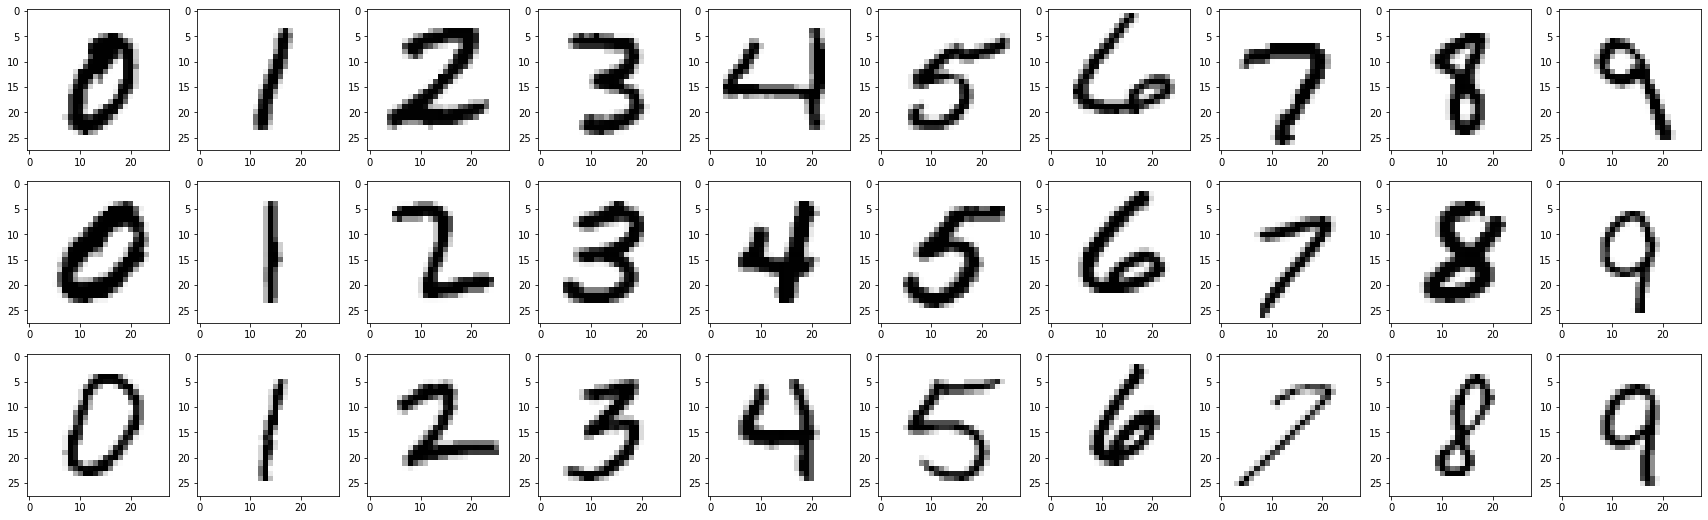

In [6]:
# data statistics
num_trainset = train_X.shape[0]
num_testset = test_X.shape[0]
H, W = train_X.shape[1], train_X.shape[2]
class_, counts = np.unique(train_y, return_counts = True)
num_class = len(class_)

print("<data statistics>")
print(f"the number of train image: {num_trainset}")
print(f"the number of test image: {num_testset}")
print(f"image size: {H} X {W}")
print(f"the number of class: {num_class}")
print(f"the number of images per each class: {dict(zip(class_, counts))}")

# visualize
show = 3
fig = plt.figure(figsize = (30, show * 3))
for n in range(num_class):
    idx = np.where(train_y == np.array([n]))[0]
    idx = np.random.choice(idx, show)
    x = train_X[idx]
    for i in range(show):
        plt.subplot(show, num_class, n + 1 + 10 * i)
        plt.imshow(x[i], cmap = plt.cm.binary)

## Forward & Backward

In [7]:
def identity_function(x):
    return x


def step_function(x):
    return np.array(x > 0, dtype=np.int)


def sigmoid(x):
    return 1 / (1 + np.exp(-x))    


def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)
    

def relu(x):
    return np.maximum(0, x)


def relu_grad(x):
    grad = np.zeros(x)
    grad[x>=0] = 1
    return grad
    

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))


def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)


def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size


def softmax_loss(X, t):
    y = softmax(X)
    return cross_entropy_error(y, t)

In [8]:
class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx


class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        out = sigmoid(x)
        self.out = out
        return out

    def backward(self, dout):
        dx = dout * (1.0 - self.out) * self.out

        return dx


class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        
        self.x = None
        self.original_x_shape = None
        # 가중치와 편향 매개변수의 미분
        self.dW = None
        self.db = None

    def forward(self, x):
        # 텐서 대응
        self.original_x_shape = x.shape
        x = x.reshape(x.shape[0], -1)
        self.x = x

        out = np.dot(self.x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)
        
        dx = dx.reshape(*self.original_x_shape)  # 입력 데이터 모양 변경(텐서 대응)
        return dx


class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None # 손실함수
        self.y = None    # softmax의 출력
        self.t = None    # 정답 레이블(원-핫 인코딩 형태)
        
    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)
        
        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        if self.t.size == self.y.size: # 정답 레이블이 원-핫 인코딩 형태일 때
            dx = (self.y - self.t) / batch_size
        else:
            dx = self.y.copy()
            dx[np.arange(batch_size), self.t] -= 1
            dx = dx / batch_size
        
        return dx

In [9]:
def _numerical_gradient_1d(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 값 복원
        
    return grad


def numerical_gradient_2d(f, X):
    if X.ndim == 1:
        return _numerical_gradient_1d(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_1d(f, x)
        
        return grad


def numerical_gradient(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 값 복원
        it.iternext()   
        
    return grad

In [10]:
class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, hidden_size) 
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        x = x.reshape(-1, 28*28)  # flatten

        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        grads['W3'] = numerical_gradient(loss_W, self.params['W3'])
        grads['b3'] = numerical_gradient(loss_W, self.params['b3'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db

        return grads

## Check gradient

In [11]:
net = TwoLayerNet(input_size=784, hidden_size=128, output_size=10)

In [12]:
numerical_grad = net.numerical_gradient(train_X[0:1], train_Y[0:1])

In [13]:
backpropagation_grad = net.gradient(train_X[0:1], train_Y[0:1])

In [14]:
print("Difference between numerical and backpropagation")
for n, b in zip(numerical_grad.items(), backpropagation_grad.items()):
    print(f"Mean abs difference of {n[0]}:", end=' ')
    print(f"{np.mean(np.abs(n[1]-b[1])):.4f}")

Difference between numerical and backpropagation
Mean abs difference of W1: 0.0000
Mean abs difference of b1: 0.0000
Mean abs difference of W2: 0.0000
Mean abs difference of b2: 0.0000
Mean abs difference of W3: 0.0000
Mean abs difference of b3: 0.0000


## Implement SGD and Train

In [15]:
# log lists
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

# hyper parameters
epochs = 10
batch_size = 100
train_size = train_X.shape[0]
lr = 0.1  # learning rate

# init network
network = TwoLayerNet(input_size=784, hidden_size=128, output_size=10)

for epoch in range(epochs):
    for b in range(0,train_size, batch_size):
        x_batch = train_X[b:b+batch_size]
        y_batch = train_Y[b:b+batch_size]

        # calculate gradient by backpropagation
        grad = network.gradient(x_batch, y_batch)

        # update(SGD)
        for k in grad.keys():
            network.params[k] -= lr * grad[k]
    
    # caculate loss & accuracy
    train_loss = network.loss(train_X, train_Y)
    train_acc = network.accuracy(train_X, train_Y)
    test_loss = network.loss(test_X, test_Y)
    test_acc = network.accuracy(test_X, test_Y)
    
    # print and logging
    print(f"{epoch}/{epochs-1}")
    print(f"train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}")
    print(f"test_loss: {test_loss:.4f}, test_acc: {test_acc:.4f}")
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)

0/9
train_loss: 0.5207, train_acc: 0.8383
test_loss: 0.5087, test_acc: 0.8451
1/9
train_loss: 0.3175, train_acc: 0.9021
test_loss: 0.3178, test_acc: 0.8989
2/9
train_loss: 0.2172, train_acc: 0.9339
test_loss: 0.2184, test_acc: 0.9305
3/9
train_loss: 0.1627, train_acc: 0.9516
test_loss: 0.1677, test_acc: 0.9482
4/9
train_loss: 0.1308, train_acc: 0.9613
test_loss: 0.1399, test_acc: 0.9579
5/9
train_loss: 0.1107, train_acc: 0.9666
test_loss: 0.1237, test_acc: 0.9625
6/9
train_loss: 0.0943, train_acc: 0.9717
test_loss: 0.1111, test_acc: 0.9660
7/9
train_loss: 0.0827, train_acc: 0.9753
test_loss: 0.1033, test_acc: 0.9674
8/9
train_loss: 0.0739, train_acc: 0.9776
test_loss: 0.0980, test_acc: 0.9687
9/9
train_loss: 0.0661, train_acc: 0.9798
test_loss: 0.0944, test_acc: 0.9706


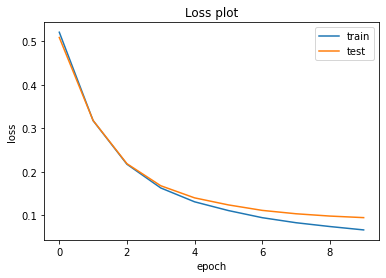

In [16]:
epochs = np.arange(0,10)
plt.plot(epochs, train_loss_list, label='train')
plt.plot(epochs, test_loss_list, label='test')
plt.title("Loss plot")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

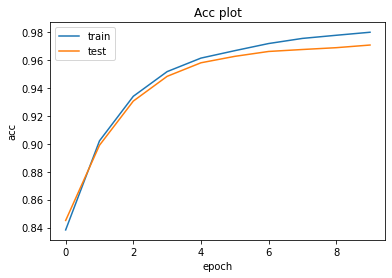

In [17]:
epochs = np.arange(0,10)
plt.plot(epochs, train_acc_list, label='train')
plt.plot(epochs, test_acc_list, label='test')
plt.title("Acc plot")
plt.xlabel('epoch')
plt.ylabel('acc')
plt.legend()
plt.show()

## (e)는 하이퍼파라미터를 변경하여 학습한 후 하나의 plot으로 비교하면 됩니다.
코드는 생략합니다